# Vgg-16_fine-tuning

### 파인튜닝

파인튜닝은 출력층 등을 변경한 모델을 학습된 모델을 기반으로 구축한 후 직접 준비한 데이터로 신경망 모델의 결합 파라미터를 학습시키는 방법이다. 결합 파라미터의 초깃값은 학습된 모델의 파라미터를 사용한다.

파인튜닝은 전이학습과는 달리 출력층 및 출력층에 가까운 부분뿐만 아니라 모든 층의 파라미터를 다시 학습시킨다. 다만 일반적으로 입력층에 가까운 부분의 파라미터는 학습률을 작게 설정하고 (경우에 따라서는 변화시키지 않고) 출력층에 가까운 부분의 파라미터는 학습률을 크게 설정한다.



### 학습 목표

1. 파이토치에서 GPU를 사용하는 코드를 작성할 수 있다.

2. 최적화 기법의 설정에서 층마다 다른 학습률을 설정한 파인튜닝을 구현할 수 있다.

3. 학습한 네트워크를 저장하고 로드할 수 있다.

### 데이터

In [1]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git
!cd pytorch advanced/
!cd 1_image_classification/

fatal: destination path 'pytorch_advanced' already exists and is not an empty directory.
/bin/bash: line 0: cd: too many arguments
/bin/bash: line 0: cd: 1_image_classification/: No such file or directory


In [2]:
import os
import urllib.request
import zipfile

In [3]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "/content/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [4]:
# ImageNetのclass_indexをダウンロードする
# Kerasで用意されているものです
# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

In [5]:
# 1.3節で使用するアリとハチの画像データをダウンロードし解凍します
# PyTorchのチュートリアルで用意されているものです
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(save_path)

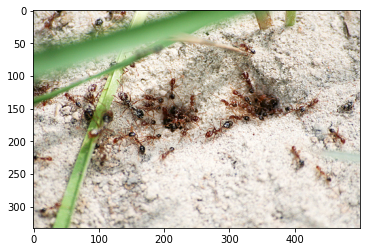

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
image_path = '/content/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg'
image = Image.open(image_path)
plt.imshow(image)

### 환경설정

In [7]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [8]:
# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### 데이터셋 작성

Dataset을 작성한다. 먼저 화상의 전처리 클래스인 ImageTransform을 만든다. 다음으로 화상 파일 경로를 리스트형 변수에 저장하는 make_datapath_list 함수를 만든다. 마지막으로 전처리 클래스와 함수를 사용하여 Dataset 클래스인 HymenopterDataset을 작성한다.

단순한 화상 분류 작업으로 Dataset을 작성할 때는 torchvision.datasets.ImageFolder 클래스로 만드는 것이 간단하다. 하지만 다양한 작업에 딥러닝을 응용할 경우 직접 Dataset을 작성할 수 있어야 한다.


먼저 화상 전처리 클래스인 ImageTransform을 만든다. 훈련시와 추론 시에 각각 다른 전처리를 해본다. 훈련 시에는 데이터 확장(data augmentation)을 실시한다. 데이터 확장이란 데이터에 대해 에폭마다 화상 변환을 다르게 적용하여 데이터를 부풀리는 기법이다. 이번에는 훈련시의 전처리에 RandomResizedCrop과 RandomHorizontalFlip을 수행한다.

전처리 클래스 ImageTransform은 다음과 같이 구현한다. RandomResizedCrop(resize, scale=(0.5,1.0))은 scale=(0.5, 1.0)은 scale에 지정된 0.5 ~ 1.0 크기로 화상을 확대 및 축소한다. 화면 비율을 3/4에서 4/3 중 하나로 변경해 화상을 가로 혹은 세로로 늘이고 마지막으로 resize에서 지정한 크기로 화상을 자른다. RandomHorizontalFlip()은 화상의 좌우를 50%의 확률로 반전시킨다. 동일한 훈련 데이터라도 에폭마다 조금씩 다른 화상이 생긴다. 다양한 데이터를 학습하여 트스트 데이터에 대한 성능 (일반화 성능) 개선에도 도움이 된다.

In [9]:
class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
          ]),
          'val' : transforms.Compose([
              transforms.Resize(resize),
              transforms.CenterCrop(resize),
              transforms.ToTensor(),
              transforms.Normalize(mean, std)
              ])
      }
  def __call__(self, img, phase='train'):
    return self.data_transform[phase](img) 

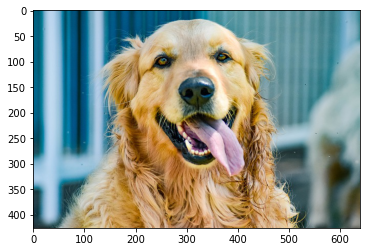

In [10]:
image_file_path = '/content/pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)
plt.imshow(img)

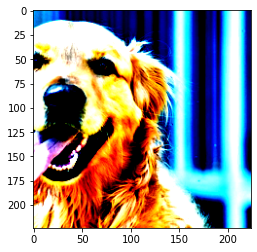

In [11]:
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(resize, mean, std)
image_transformed = transform(img, phase='train')

image_transformed = image_transformed.numpy().transpose(1,2,0)
img = np.clip(image_transformed, 0, 1)
plt.imshow(img)

이제 데이터 파일 경로를 저장하는 리스트 변수를 만든다. 이번에 사용할 훈련 데이터는 개미와 벌 화상이 총 243장, 검증 데이터는 총 153장이다. 훈련 데이터와 검증 데이터의 파일 경로 리스트를 만든다.

In [12]:
def make_datapath_list(phase = 'train'):
  root_path = '/content/hymenoptera_data/'
  target_path = osp.join(root_path + phase + '/**/*.jpg')

  path_list = []

  for path in glob.glob(target_path):
    path_list.append(path)

  return path_list

In [ ]:
train_list = make_datapath_list(phase='train')
for i in train_list:
  print(i)

In [ ]:
val_list = make_datapath_list(phase='val')
for i in val_list:
  print(i)

마지막으로 Dataset 클래스를 작성하여 훈련 데이터와 검증 데이터에 각각의 인스턴스를 만든다. 화상을 읽을 때 전처리 클래스인 imageTransform을 적용한다. 

화상이 개미라면 label을 0으로, 벌인 경우 1로 한다. Dataset 클래스를 상속한 원래의 Dataset을 만들 때는 Dataset에서 하나의 데이터를 꺼내는 메서드인 \__getitem__()과 Dataset의 파일 수를 반환하는 \__len__() 메서드를 구현해야 한다.

In [25]:
class HymenopterDataset(data.Dataset):
  def __init__(self, file_list, transform = None, phase = 'train'):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):

    # 화상 이미지 출력
    img_file_path = self.file_list[index]
    img = Image.open(img_file_path)

    # 화상 이미지 전처리
    img_transformed = self.transform(img, self.phase)

    # 레이블 값
    if self.phase == 'train':
      label = img_file_path[32:36]
    if self.phase == 'val':
      label = img_file_path[30:34]

    if label == 'ants':
      label = 0
    if label == 'bees':
      label = 1
    
    return img_transformed, label

In [26]:
train_dataset = HymenopterDataset(train_list, transform = ImageTransform(resize, mean, std), phase = 'train')
val_dataset = HymenopterDataset(val_list, transform = ImageTransform(resize, mean, std), phase = 'val')

In [33]:
index = 0
image = train_dataset.__getitem__(index)[0]

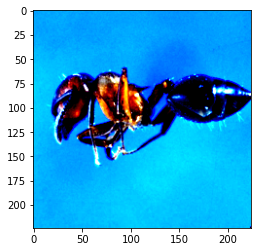

In [32]:
image = image.numpy().transpose(1,2,0)
plt.imshow(image)

In [34]:
train_dataset.__getitem__(index)[1]

0

### 데이터 로더 작성

훈련용 데이터 로더는 shuffle =True로 설정하고 화상을 꺼내는 순서가 랜덤이 되도록 한다. 훈련용 및 검증용 데이터 로더를 작성하고 양자를 사전형 변수 dataloaders_dict에 저장한다. 사전형 변수에 저장하는 것은 학습 및 검증 시 쉽게 다룩 위해서이다.

In [37]:
batch_size = 32

train_loader = data.DataLoader(dataset = train_dataset,
                               shuffle = True,
                               batch_size = batch_size)
val_loader = data.DataLoader(dataset = val_dataset,
                               shuffle = False,
                               batch_size = batch_size)

# 사전형 변수에 정리
dataloaders_dict = {'train': train_loader, 'val' : val_loader}

In [40]:
batch_iterator = iter(dataloaders_dict['train'])
batch_iterator

In [41]:
# 동작 확인
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator) # 첫번째 요소 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1])


### 네트워크 모델 작성

In [44]:
net = models.vgg16(pretrained = True)
net

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
 net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
 net 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
# 훈련 모드로 설정
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 손실함수 정의

In [48]:
criterion = nn.CrossEntropyLoss()

### 최적화 방법 설정

파인튜닝은 최적화 기법의 설정이 전이학습과 다르다. 모든 층의 파라미터를 학습할 수 있도록 옵티마이저(optimizer)를 설정한다.

먼저 각 층의 학습률을 바꿀 수 있도록 파라미터를 설정한다. VGG-16의 전반부 features 모듈의 파라미터를 update_param_names_1 변수에, 후반부 전결합 층의 classifier 모듈 중 처음 두개의 전결합 층 파라미터를 update_param_names_2 변수에, 교체한 마지막 전결합 층 파라미터를 update_param_names_3 변수에 저장한다. 각가 다른 학습률을 적용할 수 있다.

In [52]:
# 파인튜닝으로 학습할 파라미터를 params_to_update 변수의 1~3에 저장한다.

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 학습시킬 층의 파라미터명 지정
update_param_names_1 = ['features']
update_param_names_2 = ['classifier.0.weight',
                        'classifier.0.bias',
                        'classfier.3.weight',
                        'classfier.3.bias']
update_param_names_3 = ['classifier.6.weight', 'classifier.6.bias']

# 파라미터를 각 리스트에 저장
for name, param in net.named_parameters():
  if update_param_names_1[0] in name:
    param.requires_grad = True
    params_to_update_1.append(param)
    print('params_to_update_1에 저장: ', name)
  
  elif name in update_param_names_2:
    param.requires_grad = True
    params_to_update_2.append(param)
    print('params_to_update_2에 저장: ', name)
  
  elif name in update_param_names_3:
    param.requires_grad = True
    params_to_update_2.append(param)
    print('params_to_update_3에 저장: ', name)
  
  else:
    param.requires_grad = False
    print('경사 계산 없음. 학습되지 않음: ', name)


params_to_update_1에 저장:  features.0.weight
params_to_update_1에 저장:  features.0.bias
params_to_update_1에 저장:  features.2.weight
params_to_update_1에 저장:  features.2.bias
params_to_update_1에 저장:  features.5.weight
params_to_update_1에 저장:  features.5.bias
params_to_update_1에 저장:  features.7.weight
params_to_update_1에 저장:  features.7.bias
params_to_update_1에 저장:  features.10.weight
params_to_update_1에 저장:  features.10.bias
params_to_update_1에 저장:  features.12.weight
params_to_update_1에 저장:  features.12.bias
params_to_update_1에 저장:  features.14.weight
params_to_update_1에 저장:  features.14.bias
params_to_update_1에 저장:  features.17.weight
params_to_update_1에 저장:  features.17.bias
params_to_update_1에 저장:  features.19.weight
params_to_update_1에 저장:  features.19.bias
params_to_update_1에 저장:  features.21.weight
params_to_update_1에 저장:  features.21.bias
params_to_update_1에 저장:  features.24.weight
params_to_update_1에 저장:  features.24.bias
params_to_update_1에 저장:  features.26.weight
params_to_update_1

이어서 각 파라미터에 최적화 방법을 설정한다. 모멘텀SGD를 사용할 것이다. 
update_param_names_1의 학습률은 1e-4, update_param_names_2의 학습률은 5e-4, update_param_names_3의 학습률은 1e-3으로 설정한다. momentum은 모두 0.9로 한다.

      {'params' : params_to_update_1, 'lr': 1e-4}

로 작성하면 params_to_update_1의 학습률을 1e-4로 서정할 수 있다. [ ]의 외부에 작성한 파라미터는 모든 params에 동일한 값을 적용할 수 있다. momentum 값은 모두 동일하여 [ ]의 외부에 작성한다.

In [53]:
# 최적화 방법 설정
optimizer = optim.SGD([
    {'params' : params_to_update_1, 'lr': 1e-4},
    {'params' : params_to_update_2, 'lr': 5e-4},
    {'params' : params_to_update_3, 'lr': 1e-3}
], momentum = 0.9)

### 학습 및 검증 실시

모델을 훈련시키는 train_model 함수를 정의한다. 기본적으로 전이학습과 동일하지만, GPU를 사용할 수 있도록 설정을 추가한다.

GPU를 사용하려면 

    device  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU를 사용할 수 있는 경우는 device 변수에 cuda:0이 저장되고 CPU만 사용할 수 있는 경우는 cpu가 저장된다. device 변수를 사용하여 네트워크 모델, 모델에 입력할 데이터, 라벨 데이터를 GPU에 전송한다. 네트워크 모델의 변수와 데이터 변수에 .to(device)를 실행하여 GPU에 전송할 수 있다.

피이토치는 device 변수에 GPU나 CPU를 저장한다. 네트워크 모ㅗ델의 변수와 입력 데이터 변수에 .to(device)를 실행하여 GPU 머신 혹은 CPU 머신에서 동일한 코드로 프로그램을 실행할 수 있다.(여러 GPU를 동시에 사용하는 경우 제외), 또한 신경망의 순전파 및 오차 함수의 계산 방법이 반복할 때마다 어느 정도 일정하다면 

    torch.backends.cudnn.benchmark = True

라는 설정으로 GPU의 계산을 고속화한다.

In [64]:
# 모델을 학습시키는 함수 작성

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

  # 초기 설정
  # GPU가 사용 가능한지 확인
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print('사용할 장치: ', device)

  # 네트워크를 GPU로
  net.to(device)

  # 네트워크가 어느 정도 고정되면 고속화 시킨다.
  torch.backends.cudnn.benchmark = True

  # 에폭 루프
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('----------')

    # 에폭별 훈련 및 검증 루프
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      if phase == 'val':
        net.eval()
      
      epoch_loss = 0.
      epoch_corrects = 0

      # 학습하지 않았을 때의 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
      if (epoch == 0) and (phase == 'train'):
        continue
      
      # 데이터 로더에서 미니 배치를 꺼내 루프
      for inputs, labels in tqdm(dataloaders_dict[phase]):

        # GPU를 사용할 수 있다면 GPU에 데이터를 보낸다.
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파 계산
        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels) # 손실 계산
          _, preds = torch.max(outputs, 1) # 라벨 예측

          # 훈련 시에는 오차 역전파법
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # 결과 계산
          epoch_loss += loss.item() * inputs.size(0) # 손실의 합계 갱신
          # 정답 수의 합계 갱신
          epoch_corrects += torch.sum(preds == labels.data)

        # 에폭별 손실과 정답률 표시
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} ACC: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [65]:
# 학습 및 검증 실행
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

사용할 장치:  cpu
Epoch 1/2
----------


 20%|██        | 1/5 [00:17<01:08, 17.15s/it]

val Loss: 0.1806 ACC: 0.0458


 40%|████      | 2/5 [00:34<00:51, 17.08s/it]

val Loss: 0.1807 ACC: 0.1046


 60%|██████    | 3/5 [00:51<00:34, 17.05s/it]

val Loss: 0.1273 ACC: 0.2484


 80%|████████  | 4/5 [01:08<00:17, 17.05s/it]

val Loss: 0.1176 ACC: 0.4248


100%|██████████| 5/5 [01:21<00:00, 16.30s/it]


val Loss: 0.0883 ACC: 0.5621
Epoch 2/2
----------


 12%|█▎        | 1/8 [00:55<06:31, 55.94s/it]

train Loss: 0.0914 ACC: 0.0864


 25%|██▌       | 2/8 [01:50<05:31, 55.30s/it]

train Loss: 0.0927 ACC: 0.1605


 38%|███▊      | 3/8 [02:44<04:32, 54.54s/it]

train Loss: 0.0948 ACC: 0.2387


 50%|█████     | 4/8 [03:37<03:36, 54.06s/it]

train Loss: 0.0865 ACC: 0.3210


 62%|██████▎   | 5/8 [04:31<02:41, 53.78s/it]

train Loss: 0.0711 ACC: 0.4156


 75%|███████▌  | 6/8 [05:28<01:49, 54.87s/it]

train Loss: 0.0687 ACC: 0.5144


 88%|████████▊ | 7/8 [06:21<00:54, 54.44s/it]

train Loss: 0.0425 ACC: 0.6379


100%|██████████| 8/8 [06:53<00:00, 51.74s/it]


train Loss: 0.0322 ACC: 0.6996


 20%|██        | 1/5 [00:17<01:08, 17.15s/it]

val Loss: 0.0497 ACC: 0.2092


 40%|████      | 2/5 [00:34<00:51, 17.09s/it]

val Loss: 0.0651 ACC: 0.4052


 60%|██████    | 3/5 [00:51<00:34, 17.09s/it]

val Loss: 0.0526 ACC: 0.6078


 80%|████████  | 4/5 [01:08<00:17, 17.08s/it]

val Loss: 0.0513 ACC: 0.7974


100%|██████████| 5/5 [01:21<00:00, 16.33s/it]

val Loss: 0.0480 ACC: 0.9542


### 학습한 네트워크 저장 및 로드

저장할 경우에는 네트워크 모델의 net 변수를 .state_dict()를 활용해 파라미터를 사전형 변수로 꺼낸 후 torch.save()로 저장한다.

In [66]:
# 파이토치 네트워크 파라미터 저장
save_path = '/content/hymenoptera_data/weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

로드할 경우에는 torch.load()로 사전형 객체를 로드하여 네트워크를 load_state_dict()로 저장한다. GPU 상에 저장한 파일을 CPU에 로드할 때는 map_location을 사용해야 한다.


      # GPU 상에 저장된 가중치를 CPU에 로드할 경우
      load_weights = torch.load(load_path, map_location={'cuda:0': 'cpu'})
      net.load_state_dict(load_weights)

In [67]:
# 파이토치 네트워크 파라미터 로드
load_path = '/content/hymenoptera_data/weights_fine_tuning.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

<All keys matched successfully>